# Guided Test Case Generation System Notebook

In [2]:
# Basic libraries
import os, sys
import numpy as np
import re
import string
from datetime import datetime
import math
import pandas as pd

import utils

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Speech
import soundfile as sf # pip install pysoundfile
import python_speech_features as speech_lib # pip install python_speech_features


# Machine learning
import nltk
import xgboost
from sklearn.utils import shuffle
from sklearn.base import clone as clone_model
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import joblib

import tensorflow as tf


%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

### Read Data

In [9]:
DEEPSPEECH = "deepspeech"
ALEXA = "alexa"
GCLOUD = "gcloud"
CHROMESPEECH = "gspeech"
WIT = "wit"
WAV2LETTER = "wav2letter"
PADDLEDEEPSPEECH = "paddledeepspeech"
SR = [DEEPSPEECH, WIT, WAV2LETTER, PADDLEDEEPSPEECH]

df = utils.read_data("training_data/" + WIT + ".txt")


DETERMINED_LABEL = 1
UNDETERMINED_LABEL = 0

In [10]:
df.head(10)

,sentence,label
0,had laid before her a pair of alternatives now...,-1
1,property erects a kind of barrier you can do a...,-1
2,i mean of course if you'll take a companion so...,-1
3,she'd keep people off very well i think,1
4,that it's a great deal better you should remai...,1
5,she had a great regard for what was usually de...,-1
6,when she sat in her damp waterproof and sketch...,-1
7,and her imagination constantly anticipated the...,-1
8,but was never over inquisitive as regards the ...,-1
9,so little surface offered so limited a face to...,-1


#### Change the label

In [11]:
succes_test_case = np.where(df["label"] == 0)[0]
undetermined_case = np.where(df["label"] == -1)[0]

In [12]:
df["label"][succes_test_case] = 1
df["label"][undetermined_case] = 0

/Users/mhilmiasyrofi/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mhilmiasyrofi/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
df.head(10)

,sentence,label
0,had laid before her a pair of alternatives now...,0
1,property erects a kind of barrier you can do a...,0
2,i mean of course if you'll take a companion so...,0
3,she'd keep people off very well i think,1
4,that it's a great deal better you should remai...,1
5,she had a great regard for what was usually de...,0
6,when she sat in her damp waterproof and sketch...,0
7,and her imagination constantly anticipated the...,0
8,but was never over inquisitive as regards the ...,0
9,so little surface offered so limited a face to...,0


### Data distribution

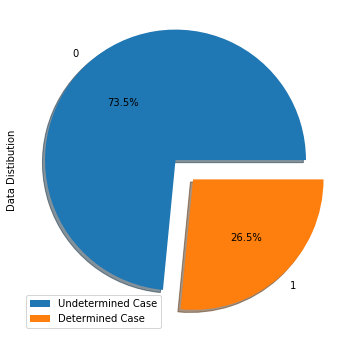

In [19]:
df["label"].value_counts().plot(kind = 'pie', explode = [0.1, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Data Distibution")
plt.legend(["Undetermined Case", "Determined Case"])
plt.show()

we need to handle imbalance data

### Handle Imbalance Data

In [18]:
RESAMPLE_SIZE = utils.getResampleSize(df)
print("Resample Size: %d" % RESAMPLE_SIZE)

sample = utils.resampleToFixNumber(df["deepspeech"], RESAMPLE_SIZE)
# sample["label"].value_counts().plot(kind = 'pie', explode = [0.1, 0.1, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
# plt.ylabel("Data Distibution")
# plt.legend(["Undetermined Label", "Non-Bug", "Bug"])
# plt.show()

AttributeError: 'Series' object has no attribute 'label'

### Feature Extraction

In [20]:
NUM_CORES = 4
EMBEDDING_SIZE = 13

In [21]:
from gensim.models import Word2Vec

corpus_sentence = pd.read_csv('corpus-sentence.txt', sep=",", header=None)
corpus_sentence.columns = ["sentence"]
tokenized_corpus = list(corpus_sentence['sentence'].apply(utils.text_process))

w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    size=EMBEDDING_SIZE,
    min_count=1,
    window=5,
    workers=NUM_CORES,
    seed=1337
)

w2v_model.save("model/word2vec.model")

# Show that similar words to 'program' print
# w2v_model.wv.most_similar(positive='program')

# Encode the documents using the new embedding
encoded_docs = [[w2v_model.wv[word] for word in sentence] for sentence in tokenized_corpus]

### Length variation on each sentence

In [22]:
print(len(encoded_docs[0]))
print(len(encoded_docs[1])) 
# print(encoded_docs[0]) 

42
40


In [23]:
def max_length_sentence_from_corpus(encoded_docs):
    max = 0
    for encoded_sentence in encoded_docs :
        if (len(encoded_sentence) > max) :
            max = len(encoded_sentence)
    return max


MAX_LENGTH = max_length_sentence_from_corpus(encoded_docs)
MAX_LENGTH

75

In [24]:
# because the length of each sentence is various 
# and we use non-sequential machine learning model
# we need to make padding for each sentences
def create_padding_on_sentence(encoded_docs) :
    padded_posts = []

    for post in encoded_docs:

        # Pad short posts with alternating min/max
        if len(post) < MAX_LENGTH:

            padding_size = MAX_LENGTH - len(post)

            for _ in range(0, padding_size) :
                post.append(np.zeros((EMBEDDING_SIZE)))


        # Shorten long posts or those odd number length posts we padded to MAX_LENGTH
        if len(post) > MAX_LENGTH:
            post = post[:MAX_LENGTH]

        # Add the post to our new list of padded posts
        padded_posts.append(post)
    
    return padded_posts

In [25]:
def flatten_docs(padded_docs) :
    flatten = []
    for sentence in padded_docs:
        ps = []
        for word in sentence :
            for feature in word :
                ps.append(feature)
        flatten.append(ps)
    return np.asarray(flatten)

In [27]:
temp_data = utils.shuffle_data(df)

In [28]:
temp_data.head()

,sentence,label
0,and ran home killed all their cows and strippe...,1
1,the murder of clerval and lastly of my wife ev...,1
2,at certain seasons of the year when salmon wer...,1
3,the cost to the government has been variously ...,0
4,he put a paper donkey's head unexpectedly on f...,0


In [29]:
def extract_feature(docs) :
    tokenized_sentences = docs.apply(utils.text_process)
    encoded_docs = [[w2v_model.wv[word] for word in sentence] for sentence in tokenized_sentences]
    padded_docs = create_padding_on_sentence(encoded_docs)
    flatten_array = flatten_docs(padded_docs)
    return flatten_array

In [30]:
temp_data["sentence"][0]

'and ran home killed all their cows and stripped off their skins in order to sell them in the town to the greatest advantage the mayor however said but my servant must go first'

In [31]:
flatten_array = extract_feature(temp_data['sentence'])

In [32]:
# flatten_array[0]

In [40]:
# https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = RandomForestClassifier(n_estimators=31, random_state=111)

    
    score = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8,shuffle=True), n_jobs=4, verbose=2)
    return np.mean(score)

In [34]:
evaluate_features(flatten_array, temp_data["label"])

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   35.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   35.5s finished


0.7676863351158151

## Experiment

### Prepare Model

In [35]:
N_JOBS = 4

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=10)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='lbfgs', n_jobs=N_JOBS)
rfc = RandomForestClassifier(n_estimators=31, random_state=111, n_jobs=N_JOBS)
abc = AdaBoostClassifier(n_estimators=31, random_state=111)
bc = BaggingClassifier(n_estimators=10, random_state=111, n_jobs=N_JOBS)
etc = ExtraTreesClassifier(n_estimators=10, random_state=111, n_jobs=N_JOBS)
xgb = xgboost.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)

In [42]:
clfs = {'KN' : knc, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc }

### Model Evaluation

In [43]:
feature = extract_feature(df["sentence"])
label = df["label"]

#### Performance

In [44]:
for clf_name, clf in clfs.items() :
    accuracy = evaluate_features(feature, label, clf)

    print('Average accuracy %s: %.2f' % (clf_name, accuracy))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

### Trying Model in the First Batch

In [45]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
    
def predict_labels(clf, features):
    return clf.predict(features)

# intersection between 2 sets
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

In [73]:
FIRST_BATCH_SIZE = math.ceil(len(df["label"]) * 3 / 4 )
BATCH_SIZE = math.ceil(len(df["label"]) / 2 / 3)
MAX_SIZE = len(df["label"])

df = utils.shuffle_data(df)

feature = extract_feature(df["sentence"][:FIRST_BATCH_SIZE])
label = df["label"][:FIRST_BATCH_SIZE]

In [74]:
models = {}
# selected_clfs = ["SVC", "KN", "NB", "DT", "LR", "RF", "AdaBoost", "BgC", "ETC", "XGB"]
# selected_clfs = ["SVC", "KN", "NB", "DT", "LR", "AdaBoost", "XGB"]
# selected_clfs = ["AdaBoost"]
selected_clfs = ["KN", "DT", "LR", "RF", "AdaBoost", "ETC"]
for k in selected_clfs :
    model = clone_model(clfs[k])
    train_classifier(model, feature, label)
    models[k] = model
    
for clf in models.keys() :
    filename = "model/" + clf + ".sav"
    joblib.dump(models[clf], filename)

### Trying Model for the Next Batch until Finish

In [71]:
performance_writer = open(
        "performance/2_label_word2vec_" + str(datetime.now()) + ".txt", "w+")


for key_clf, model in models.items() :
    # classify the selected data
    training_data = df[:FIRST_BATCH_SIZE]

    lower_bound = FIRST_BATCH_SIZE

    columns = ["True", "Positive", "TP", "Precision", "Recall", "F1"]
    index = []
    performance_data = []

    while (lower_bound < MAX_SIZE) :
        # set the upper bound size
        upper_bound = lower_bound + BATCH_SIZE
        if (upper_bound > MAX_SIZE) :
            upper_bound = MAX_SIZE
        batch = str(lower_bound) + " - " + str(upper_bound)
        index.append(batch)
            
            
        # get the data to be selected
        current_data = df[lower_bound:upper_bound]

        # get the feature and label
        current_feature = extract_feature(current_data["sentence"])
        
        # predict the current data
        prediction = predict_labels(model, current_feature)

        d = {
             "sentence": current_data["sentence"].values,
             "label" : current_data["label"].values,
             "prediction" : prediction
            }


        df_per_batch = pd.DataFrame(data=d)

        
        predicted_determined = np.where(df_per_batch["prediction"] == DETERMINED_LABEL)[0]
        actual_determined = np.where(df_per_batch["label"] == DETERMINED_LABEL)[0]
        
        correctly_predicted_determined = utils.intersection(predicted_determined, actual_determined)
        
        
        precision = 0
        if (len(predicted_determined) != 0) :
            precision = round(len(correctly_predicted_determined)/len(predicted_determined), 2)
        recall = 0
        if (len(actual_determined) != 0) :
            recall = round(len(correctly_predicted_determined)/len(actual_determined), 2)
        precision_add_recall = precision + recall
        f1 = 0
        if precision_add_recall != 0 :
            f1 = round( 2 * precision * recall / (precision_add_recall), 2)
        performance_data.append(
            [len(actual_determined), 
             len(predicted_determined), 
             len(correctly_predicted_determined), 
             precision, recall, f1])
        
        # add the predicted data to previous data
        if (len(correctly_predicted_determined) > 0) :
            added_data = current_data.iloc[correctly_predicted_determined,:]
            training_data.append(added_data)

            # re-extract feature
            current_feature = extract_feature(training_data["sentence"])
            current_label = training_data["label"]

            # re-train the model 
            train_classifier(model, current_feature, current_label)

        # update the lower bound
        lower_bound = upper_bound

    performance = pd.DataFrame(performance_data, index=index, columns=columns)
    
    print("Classifier: " + key_clf) 
    print(performance)
    actual_determined =  int(performance["True"].sum(axis=0))
    predicted_determined = int(performance["Positive"].sum(axis=0))
    correctly_predicted_determined = int(performance["TP"].sum(axis=0))
    precision = round(performance["Precision"].mean(), 2)
    recall = round(performance["Recall"].mean(), 2)
    f1 = round(performance["F1"].mean(), 2)
    
    print("Actual Fail Test Case: %d" % (actual_determined))
    print("Predicted Fail Test Case: %d" % (predicted_determined))
    print("Correctly Predicted Fail Test Case: %d" % (correctly_predicted_determined))
    print("Precision: %.2f" % (precision))
    print("Recall: %.2f" % (recall))
    print("F1: %.2f" % (f1))
    print("\n")
    
    performance_writer.write("Classifier: %s" % (key_clf))
    performance_writer.write("\n" + str(performance))
    performance_writer.write("\nActual Fail Test Case: %d" % (actual_determined))
    performance_writer.write("\nPredicted Fail Test Case: %d" % (predicted_determined))
    performance_writer.write("\nCorrectly Predicted Fail Test Case: %d" % (correctly_predicted_determined))
    performance_writer.write("\nPrecision: %.2f" % (precision))
    performance_writer.write("\nRecall: %.2f" % (recall))
    performance_writer.write("\nF1: %.2f" % (f1))
    performance_writer.write("\n\n")

performance_writer.close()

Classifier: KN
               True  Positive   TP  Precision  Recall    F1
21405 - 26162  1274      1198  439       0.37    0.34  0.35
26162 - 28539   644       601  223       0.37    0.35  0.36
Actual Fail Test Case: 1918
Predicted Fail Test Case: 1799
Correctly Predicted Fail Test Case: 662
Precision: 0.37
Recall: 0.34
F1: 0.36


Classifier: DT
               True  Positive   TP  Precision  Recall    F1
21405 - 26162  1274      1305  453       0.35    0.36  0.35
26162 - 28539   644       666  243       0.36    0.38  0.37
Actual Fail Test Case: 1918
Predicted Fail Test Case: 1971
Correctly Predicted Fail Test Case: 696
Precision: 0.36
Recall: 0.37
F1: 0.36


Classifier: LR
               True  Positive   TP  Precision  Recall    F1
21405 - 26162  1274       588  373       0.63    0.29  0.40
26162 - 28539   644       279  171       0.61    0.27  0.37
Actual Fail Test Case: 1918
Predicted Fail Test Case: 867
Correctly Predicted Fail Test Case: 544
Precision: 0.62
Recall: 0.28
F1: 0.38

